## Importando DS e bibliotecas

In [89]:
!wget "https://github.com/augustolnb/LAMIA/raw/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip"

--2025-08-14 12:26:13--  https://github.com/augustolnb/LAMIA/raw/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/augustolnb/LAMIA/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip [following]
--2025-08-14 12:26:13--  https://raw.githubusercontent.com/augustolnb/LAMIA/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21210526 (20M) [application/zip]
Saving to: ‘dataset-dental-floss.zip.2’

dataset-dental-flos 100%[===================>]  20.23M  --.-KB/s    in 0.09s   

2025-08-14

In [90]:
!mkdir /content/ds

mkdir: cannot create directory ‘/content/ds’: File exists


In [91]:
!unzip /content/dataset-dental-floss.zip -d /content/ds

Archive:  /content/dataset-dental-floss.zip
replace /content/ds/empty/empty_004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [92]:
import os
import cv2
import zipfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [127]:
# Caminho do dataset

dataset_dir = pathlib.Path('/content/ds/')

# Parâmetros das imagens
image_size = (128, 128)
batch_size = 256

## Preparação dos dados

In [135]:
# Dividir dataset

# Conjunto de Treino (75%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.25,  # 25% do dataset para validação e teste
    subset='training',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

# Conjunto de Validação (15%) e Teste (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.25,
    subset='validation',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 4066 files belonging to 2 classes.
Using 3050 files for training.
Found 4066 files belonging to 2 classes.
Using 1016 files for validation.


In [136]:
# Normalizar as imagens

normalizacao = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizacao(x), y))
val_ds = val_ds.map(lambda x, y: (normalizacao(x), y))

In [137]:
# Dividir validação e teste
# 'val_ds' tem 25% dos dados.
# 60% de 25% = 15% do total
# 40% de 25% = 10% do total

val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(tf.cast(tf.cast(val_batches, tf.float32) * 0.4, tf.int64))
val_ds = val_ds.skip(tf.cast(tf.cast(val_batches, tf.float32) * 0.4, tf.int64))

In [138]:
# Verificando os conjuntos

print(f"Número de lotes de treinamento: {tf.data.experimental.cardinality(train_ds)}")
print(f"Número de lotes de validação: {tf.data.experimental.cardinality(val_ds)}")
print(f"Número de lotes de teste: {tf.data.experimental.cardinality(test_ds)}")

Número de lotes de treinamento: 12
Número de lotes de validação: 3
Número de lotes de teste: 1


In [139]:
# Configuração para desempenho
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [140]:
# data augmentation para o conjunto de treino
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # espelhamento horizontal
    layers.RandomContrast(0.2)       # variação de contraste
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [141]:
num_classes = 2

# Otimização Bayesiana x Grid Search

## Otimização bayesiana

### Inferindo valores de hiperparâmetros

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 1)))

    for i in range(hp.Int("num_conv_layers", 1, 6, default=2)):
        model.add(layers.Conv2D(filters=hp.Int(f"filters_{i}", min_value=16, max_value=256, step=16), kernel_size=3, activation="relu"))
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int("dense_units", min_value=16, max_value=256, step=16), activation="relu"))
    model.add(layers.Dropout(hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)))
    model.add(layers.Dense(2))

    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt
import os
import sys

os.makedirs('temp_checkpoints', exist_ok=True)

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=30,  # Número de combinações de hiperparâmetros a serem testadas
    executions_per_trial=1, # Para não treinar o mesmo modelo várias vezes
    overwrite=True,
    directory="meus_modelos",
    project_name="otimizacao_bayesiana",
)

original_stdout = sys.stdout  # Salva o stdout original
output_log_file = 'training_log.txt'
with open(output_log_file, 'w') as f:
    sys.stdout = f  # Redireciona stdout para o arquivo

    print("Iniciando a busca de hiperparâmetros...")
    tuner.search(train_ds, epochs=20, validation_data=val_ds)
    print("Busca de hiperparâmetros concluída.")

    sys.stdout = original_stdout  # Restaura o stdout original

print(f"\n--- A saída completa do treinamento foi salva em: {output_log_file} ---\n")

print("\n--- Resumo dos Melhores Resultados ---")
tuner.results_summary(num_trials=3)

print("\n--- Treinando o modelo final com os melhores hiperparâmetros ---")
print("Melhores hiperparâmetros encontrados:")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


--- A saída completa do treinamento foi salva em: training_log.txt ---


--- Resumo dos Melhores Resultados ---
Results summary
Results in meus_modelos/otimizacao_bayesiana
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
num_conv_layers: 5
filters_0: 160
filters_1: 128
dense_units: 128
dropout_rate: 0.45
learning_rate: 3.799327039160936e-05
filters_2: 144
filters_3: 240
filters_4: 112
filters_5: 112
Score: 0.8655063509941101

Trial 24 summary
Hyperparameters:
num_conv_layers: 5
filters_0: 224
filters_1: 80
dense_units: 112
dropout_rate: 0.25
learning_rate: 8.02205783614031e-05
filters_2: 240
filters_3: 208
filters_4: 48
filters_5: 112
Score: 0.8623417615890503

Trial 09 summary
Hyperparameters:
num_conv_layers: 4
filters_0: 160
filters_1: 224
dense_units: 176
dropout_rate: 0.15000000000000002
learning_rate: 0.0006485405037463855
filters_2: 224
filters_3: 96
filters_4: 112
filters_5: 32
Score: 0.857594907283783

--- Treinando o m

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Treinando o modelo final com os melhores hiperparâmetros ---")
print("Melhores hiperparâmetros encontrados:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


--- Treinando o modelo final com os melhores hiperparâmetros ---
Melhores hiperparâmetros encontrados:
num_conv_layers: 5
filters_0: 160
filters_1: 128
dense_units: 128
dropout_rate: 0.45
learning_rate: 3.799327039160936e-05
filters_2: 144
filters_3: 240
filters_4: 112
filters_5: 112


In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_checkpoint_filepath = 'final_best_model.weights.h5'
final_model_checkpoint = ModelCheckpoint(
    filepath=final_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = final_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[final_model_checkpoint]
)

final_model.load_weights(final_checkpoint_filepath)
print("\n--- Modelo final com os melhores pesos carregados ---")

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.5182 - loss: 0.6923 - val_accuracy: 0.4873 - val_loss: 0.6931
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5498 - loss: 0.6864 - val_accuracy: 0.5775 - val_loss: 0.6796
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6178 - loss: 0.6681 - val_accuracy: 0.6487 - val_loss: 0.6273
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6405 - loss: 0.6367 - val_accuracy: 0.6630 - val_loss: 0.5994
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6567 - loss: 0.6143 - val_accuracy: 0.6788 - val_loss: 0.5734
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6829 - loss: 0.6007 - val_accuracy: 0.7184 - val_loss: 0.5507
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6956 - loss: 0.5773 - val_accuracy: 0.7373 - val_loss: 0.5252
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7172 - loss: 0.5534 - val_accuracy: 0.7785 - 

### Analisando o modelo bayesiano

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
--- Relatório de Métricas do Modelo ---

Matriz de Confusão:


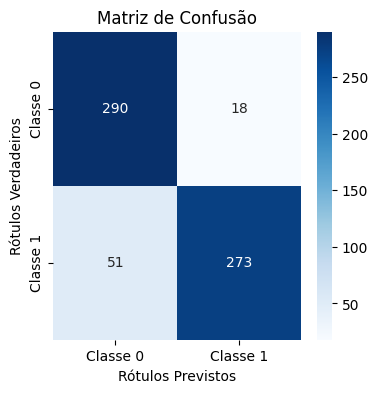



--- Métricas de Avaliação ---
 Precisão (média): 0.8943
 Recall (média): 0.8921
-----------------------------


AUC (Área Sob a Curva ROC): 0.9661


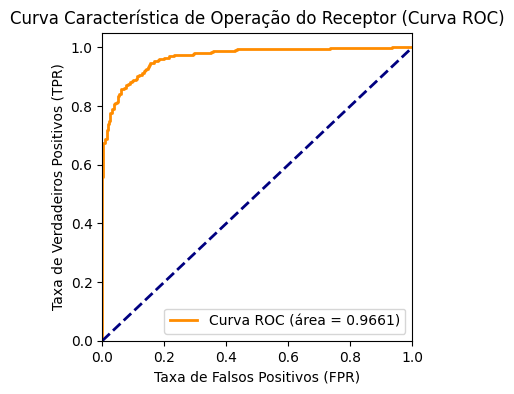

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

y_pred_logits = final_model.predict(val_ds)
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)

y_pred_class = np.argmax(y_pred_prob, axis=1)

print("--- Relatório de Métricas do Modelo ---")

# matriz de confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulos Verdadeiros')
plt.xlabel('Rótulos Previstos')
plt.show()

print("\n\n--- Métricas de Avaliação ---")
precision = precision_score(y_true, y_pred_class, average='macro')
recall = recall_score(y_true, y_pred_class, average='macro')
print(f" Precisão (média): {precision:.4f}")
print(f" Recall (média): {recall:.4f}")
print("-----------------------------\n\n")

y_pred_prob_positive = y_pred_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_positive)
roc_auc = auc(fpr, tpr)

print(f"AUC (Área Sob a Curva ROC): {roc_auc:.4f}")

# curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva Característica de Operação do Receptor (Curva ROC)')
plt.legend(loc="lower right")
plt.show()

## Grid Search Orientado

In [ ]:
learning_rates = [4e-5, 5e-5, 6e-5, 7e-5, 8e-5]
dropout_rates = [0.25, 0.3, 0.35, 0.4, 0.45]
neurons_num = [96, 112, 128, 144]

results = []
best_val_accuracy = 0
best_hyperparams = {}

#### Modelo da combinação #7

In [ ]:
def create_model(learning_rate, dropout_rate, neurons_num):
    model = keras.Sequential([
        layers.Input(shape=(128, 128, 1)),

        layers.Conv2D(160, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(144, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(240, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(112, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(neurons_num, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

#### Modelo da combinação #25

In [ ]:
def create_model(learning_rate, dropout_rate, neurons_num):
    model = keras.Sequential([
        layers.Input(shape=(128, 128, 1)),

        layers.Conv2D(224, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(80, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(240, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(208, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(48, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(neurons_num, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

#### Iniciando o Grid Search

In [ ]:
print("Iniciando o Grid Search...")
for lr in learning_rates:
    for dr in dropout_rates:
        for neurons in neurons_num:
            print(f"\n--- Testando: lr={lr}, dropout_rate={dr}, neurons_num={neurons} ---")

            # Construir o modelo com a combinação atual
            model = create_model(learning_rate=lr, dropout_rate=dr, neurons_num=neurons)

            # Treinar o modelo
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=10,
                verbose=0
            )

            # desempenho na validação
            val_acc = history.history['val_accuracy'][-1]
            results.append({'lr': lr, 'dropout_rate': dr, 'val_accuracy': val_acc, 'neurons_num': neurons})

            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_hyperparams = {'lr': lr, 'dropout_rate': dr, 'neurons_num': neurons}

            print(f"Acurácia de validação: {val_acc:.4f}")

print("\n--- Grid Search Concluído ---")

Iniciando o Grid Search...

--- Testando: lr=4e-05, dropout_rate=0.25, neurons_num=96 ---
Acurácia de validação: 0.7943

--- Testando: lr=4e-05, dropout_rate=0.25, neurons_num=112 ---
Acurácia de validação: 0.7991

--- Testando: lr=4e-05, dropout_rate=0.25, neurons_num=128 ---
Acurácia de validação: 0.7959

--- Testando: lr=4e-05, dropout_rate=0.25, neurons_num=144 ---
Acurácia de validação: 0.8054

--- Testando: lr=4e-05, dropout_rate=0.3, neurons_num=96 ---
Acurácia de validação: 0.8101

--- Testando: lr=4e-05, dropout_rate=0.3, neurons_num=112 ---
Acurácia de validação: 0.7880

--- Testando: lr=4e-05, dropout_rate=0.3, neurons_num=128 ---
Acurácia de validação: 0.7864

--- Testando: lr=4e-05, dropout_rate=0.3, neurons_num=144 ---
Acurácia de validação: 0.8022

--- Testando: lr=4e-05, dropout_rate=0.35, neurons_num=96 ---
Acurácia de validação: 0.7753

--- Testando: lr=4e-05, dropout_rate=0.35, neurons_num=112 ---
Acurácia de validação: 0.7848

--- Testando: lr=4e-05, dropout_rate=0.

### Testando combinações




#### ESTRUTURA # 7
1. Neuronios:112 | Dropout:0.25 | Learning Rate: 6e-05
2. Neuronios:128 | Dropout:0.25 | Learning Rate: 7e-05
3. Neuronios:112 | Dropout:0.30 | Learning Rate: 7e-05
4. Neuronios:144 | Dropout:0.35 | Learning Rate: 6e-05


In [ ]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(160, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(144, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(240, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(112, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.45),
    layers.Dense(num_classes)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=3.79e-05)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#### ESTRUTURA # 25
1. Neuronios:128 | Dropout:0.25 | Learning Rate: 7e-05
2. Neuronios: 96 | Dropout:0.25 | Learning Rate: 8e-05
3. Neuronios:144 | Dropout:0.25 | Learning Rate: 8e-05
4. Neuronios:112 | Dropout:0.30 | Learning Rate: 8e-05



In [ ]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(224, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(240, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(208, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(48, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(112, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=8e-05)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#### Avaliação

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/best_model.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
print("Iniciando o treinamento do modelo...")
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]  # callback
)

print("\nTreinamento concluído. O melhor modelo foi salvo em:", checkpoint_filepath)


Iniciando o treinamento do modelo...
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.5164 - loss: 0.6927 - val_accuracy: 0.4937 - val_loss: 0.6911
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5595 - loss: 0.6839 - val_accuracy: 0.6155 - val_loss: 0.6718
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6155 - loss: 0.6616 - val_accuracy: 0.6551 - val_loss: 0.6339
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6379 - loss: 0.6332 - val_accuracy: 0.6709 - val_loss: 0.6088
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6572 - loss: 0.6118 - val_accuracy: 0.6709 - val_loss: 0.5984
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6717 - loss: 0.6013 - val_accuracy: 0.6772 - val_loss: 0.5799
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6949 - loss: 0.5861 - val_accuracy: 0.6820 - val_loss: 0.5530
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7057 - l

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
--- Relatório de Métricas do Modelo ---


--- Métricas de Avaliação ---
 Acurácia: 0.8892
 Precisão (média): 0.8965
 Recall (média): 0.8910
AUC (Área Sob a Curva ROC): 0.9622
-----------------------------



Matriz de Confusão:


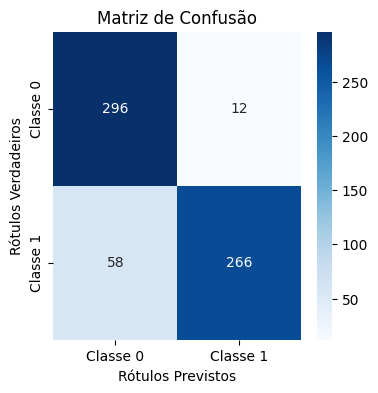

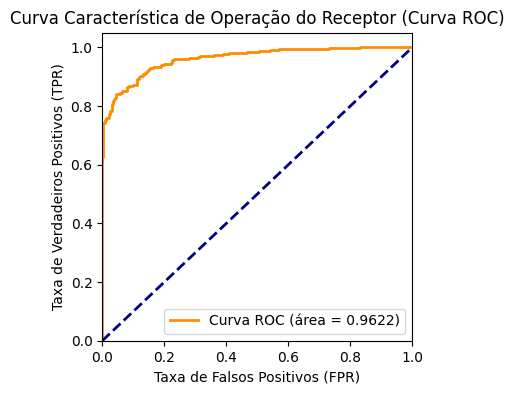

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

model.load_weights(checkpoint_filepath)

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

y_pred_logits = model.predict(val_ds)
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)

y_pred_class = np.argmax(y_pred_prob, axis=1)

print("--- Relatório de Métricas do Modelo ---")



print("\n\n--- Métricas de Avaliação ---")
loss, accuracy = model.evaluate(val_ds, verbose=0)
print(f" Acurácia: {accuracy:.4f}")
precision = precision_score(y_true, y_pred_class, average='macro')
recall = recall_score(y_true, y_pred_class, average='macro')
print(f" Precisão (média): {precision:.4f}")
print(f" Recall (média): {recall:.4f}")
y_pred_prob_positive = y_pred_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_positive)
roc_auc = auc(fpr, tpr)

print(f"AUC (Área Sob a Curva ROC): {roc_auc:.4f}")

print("-----------------------------\n\n")



# matriz de confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulos Verdadeiros')
plt.xlabel('Rótulos Previstos')
plt.show()


# curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva Característica de Operação do Receptor (Curva ROC)')
plt.legend(loc="lower right")
plt.show()

# Versão final

## Configurando o modelo final

### Modelo

In [142]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(160, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(144, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(240, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(112, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.45),
    layers.Dense(num_classes)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=3.79e-05)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [174]:
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)              │ (None, 126, 126, 160)  │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 63, 63, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 61, 61, 128)    │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 28, 28, 144)    │       166,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 14, 14, 144)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 12, 12, 240)    │       311,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 6, 6, 240)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 4, 4, 112)      │       242,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,889,368 (11.02 MB)

 Trainable params: 963,122 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,926,246 (7.35 MB)

### Treinamento

In [144]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/best_model.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

print("Iniciando o treinamento do modelo...")
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]  # callback
)

print("\nTreinamento concluído. Os melhores pesos foram salvos em:", checkpoint_filepath)


Iniciando o treinamento do modelo...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.5154 - loss: 0.6922 - val_accuracy: 0.4974 - val_loss: 0.6918
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - accuracy: 0.5368 - loss: 0.6895 - val_accuracy: 0.4987 - val_loss: 0.6903
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - accuracy: 0.5518 - loss: 0.6887 - val_accuracy: 0.5382 - val_loss: 0.6880
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.5878 - loss: 0.6861 - val_accuracy: 0.6237 - val_loss: 0.6846
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.6107 - loss: 0.6830 - val_accuracy: 0.6553 - val_loss: 0.6795
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.6265 - loss: 0.6787 - val_accuracy: 0.6618 - val_loss: 0.6718
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.6267 - loss: 0.6715 - val_accuracy: 0.6447 - val_loss: 0.6610
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.640

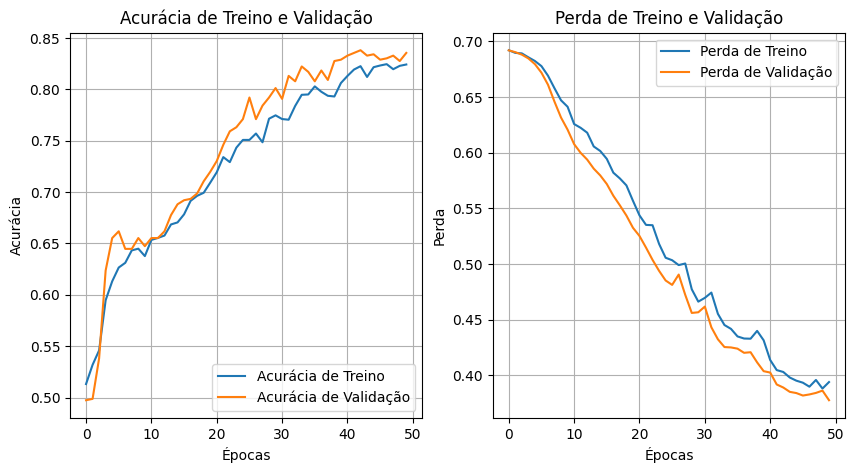


--- Resultados Finais ---
Acurácia final de Treino: 0.8243
Acurácia final de Validação: 0.8355
Perda final de Treino: 0.3939
Perda final de Validação: 0.3776


In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Acurácia do conjunto de validação
loss = history.history['loss']
val_loss = history.history['val_loss']    # Perda do conjunto de validação

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))

# --- Gráfico de Acurácia ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)

# --- Gráfico de Perda (Loss) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True)

plt.show()

# Exibe os valores finais de acurácia e perda
final_acc = acc[-1]
final_val_acc = val_acc[-1]
final_loss = loss[-1]
final_val_loss = val_loss[-1]

print("\n--- Resultados Finais ---")
print(f"Acurácia final de Treino: {final_acc:.4f}")
print(f"Acurácia final de Validação: {final_val_acc:.4f}")
print(f"Perda final de Treino: {final_loss:.4f}")
print(f"Perda final de Validação: {final_val_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
--- Relatório de Métricas do Modelo ---


--- Métricas de Avaliação ---
 Acurácia: 0.8382
 Precisão (média): 0.8386
 Recall (média): 0.8383
AUC (Área Sob a Curva ROC): 0.9116
-----------------------------



Matriz de Confusão:


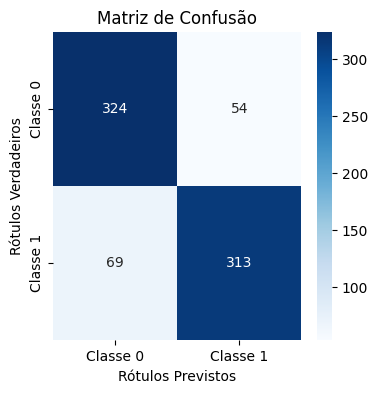

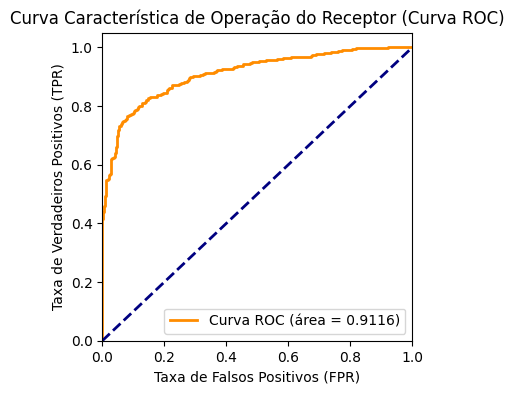

In [146]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

model.load_weights(checkpoint_filepath)

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

y_pred_logits = model.predict(val_ds)
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)

y_pred_class = np.argmax(y_pred_prob, axis=1)

print("--- Relatório de Métricas do Modelo ---")



print("\n\n--- Métricas de Avaliação ---")
loss, accuracy = model.evaluate(val_ds, verbose=0)
print(f" Acurácia: {accuracy:.4f}")
precision = precision_score(y_true, y_pred_class, average='macro')
recall = recall_score(y_true, y_pred_class, average='macro')
print(f" Precisão (média): {precision:.4f}")
print(f" Recall (média): {recall:.4f}")
y_pred_prob_positive = y_pred_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_positive)
roc_auc = auc(fpr, tpr)

print(f"AUC (Área Sob a Curva ROC): {roc_auc:.4f}")

print("-----------------------------\n\n")


# matriz de confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulos Verdadeiros')
plt.xlabel('Rótulos Previstos')
plt.show()


# curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva Característica de Operação do Receptor (Curva ROC)')
plt.legend(loc="lower right")
plt.show()

### Predição

In [148]:

def prever_nova_imagem(caminho_imagem, model):

    img = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Erro: Não foi possível carregar a imagem em {caminho_imagem}")
        return None, None

    img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

    # normalização
    img_normalized = img_resized.astype("float32") / 255.0

    # ajuste de dimensões
    img_tensor = np.expand_dims(img_normalized, axis=-1)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # predição
    predictions = model.predict(img_tensor)

    # coletando logit com a maior probabilidade
    predicted_class_index = np.argmax(predictions, axis=1)

    probabilities = tf.nn.softmax(predictions).numpy()[0]

    class_names = ['empty', 'full']
    predicted_class = class_names[predicted_class_index[0]]

    return predicted_class, probabilities


In [166]:
caminho_da_nova_imagem = '/content/predict/full06.png'

classe_predita, probabilidades = prever_nova_imagem(caminho_da_nova_imagem, model)

if classe_predita:
    print("\n--- Resultado da Predição ---")
    print(f"A imagem é provavelmente: {classe_predita}")
    print(f"Probabilidade de ser 'empty': {probabilidades[0]:.2f}")
    print(f"Probabilidade de ser 'full': {probabilidades[1]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

--- Resultado da Predição ---
A imagem é provavelmente: full
Probabilidade de ser 'empty': 0.04
Probabilidade de ser 'full': 0.96


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


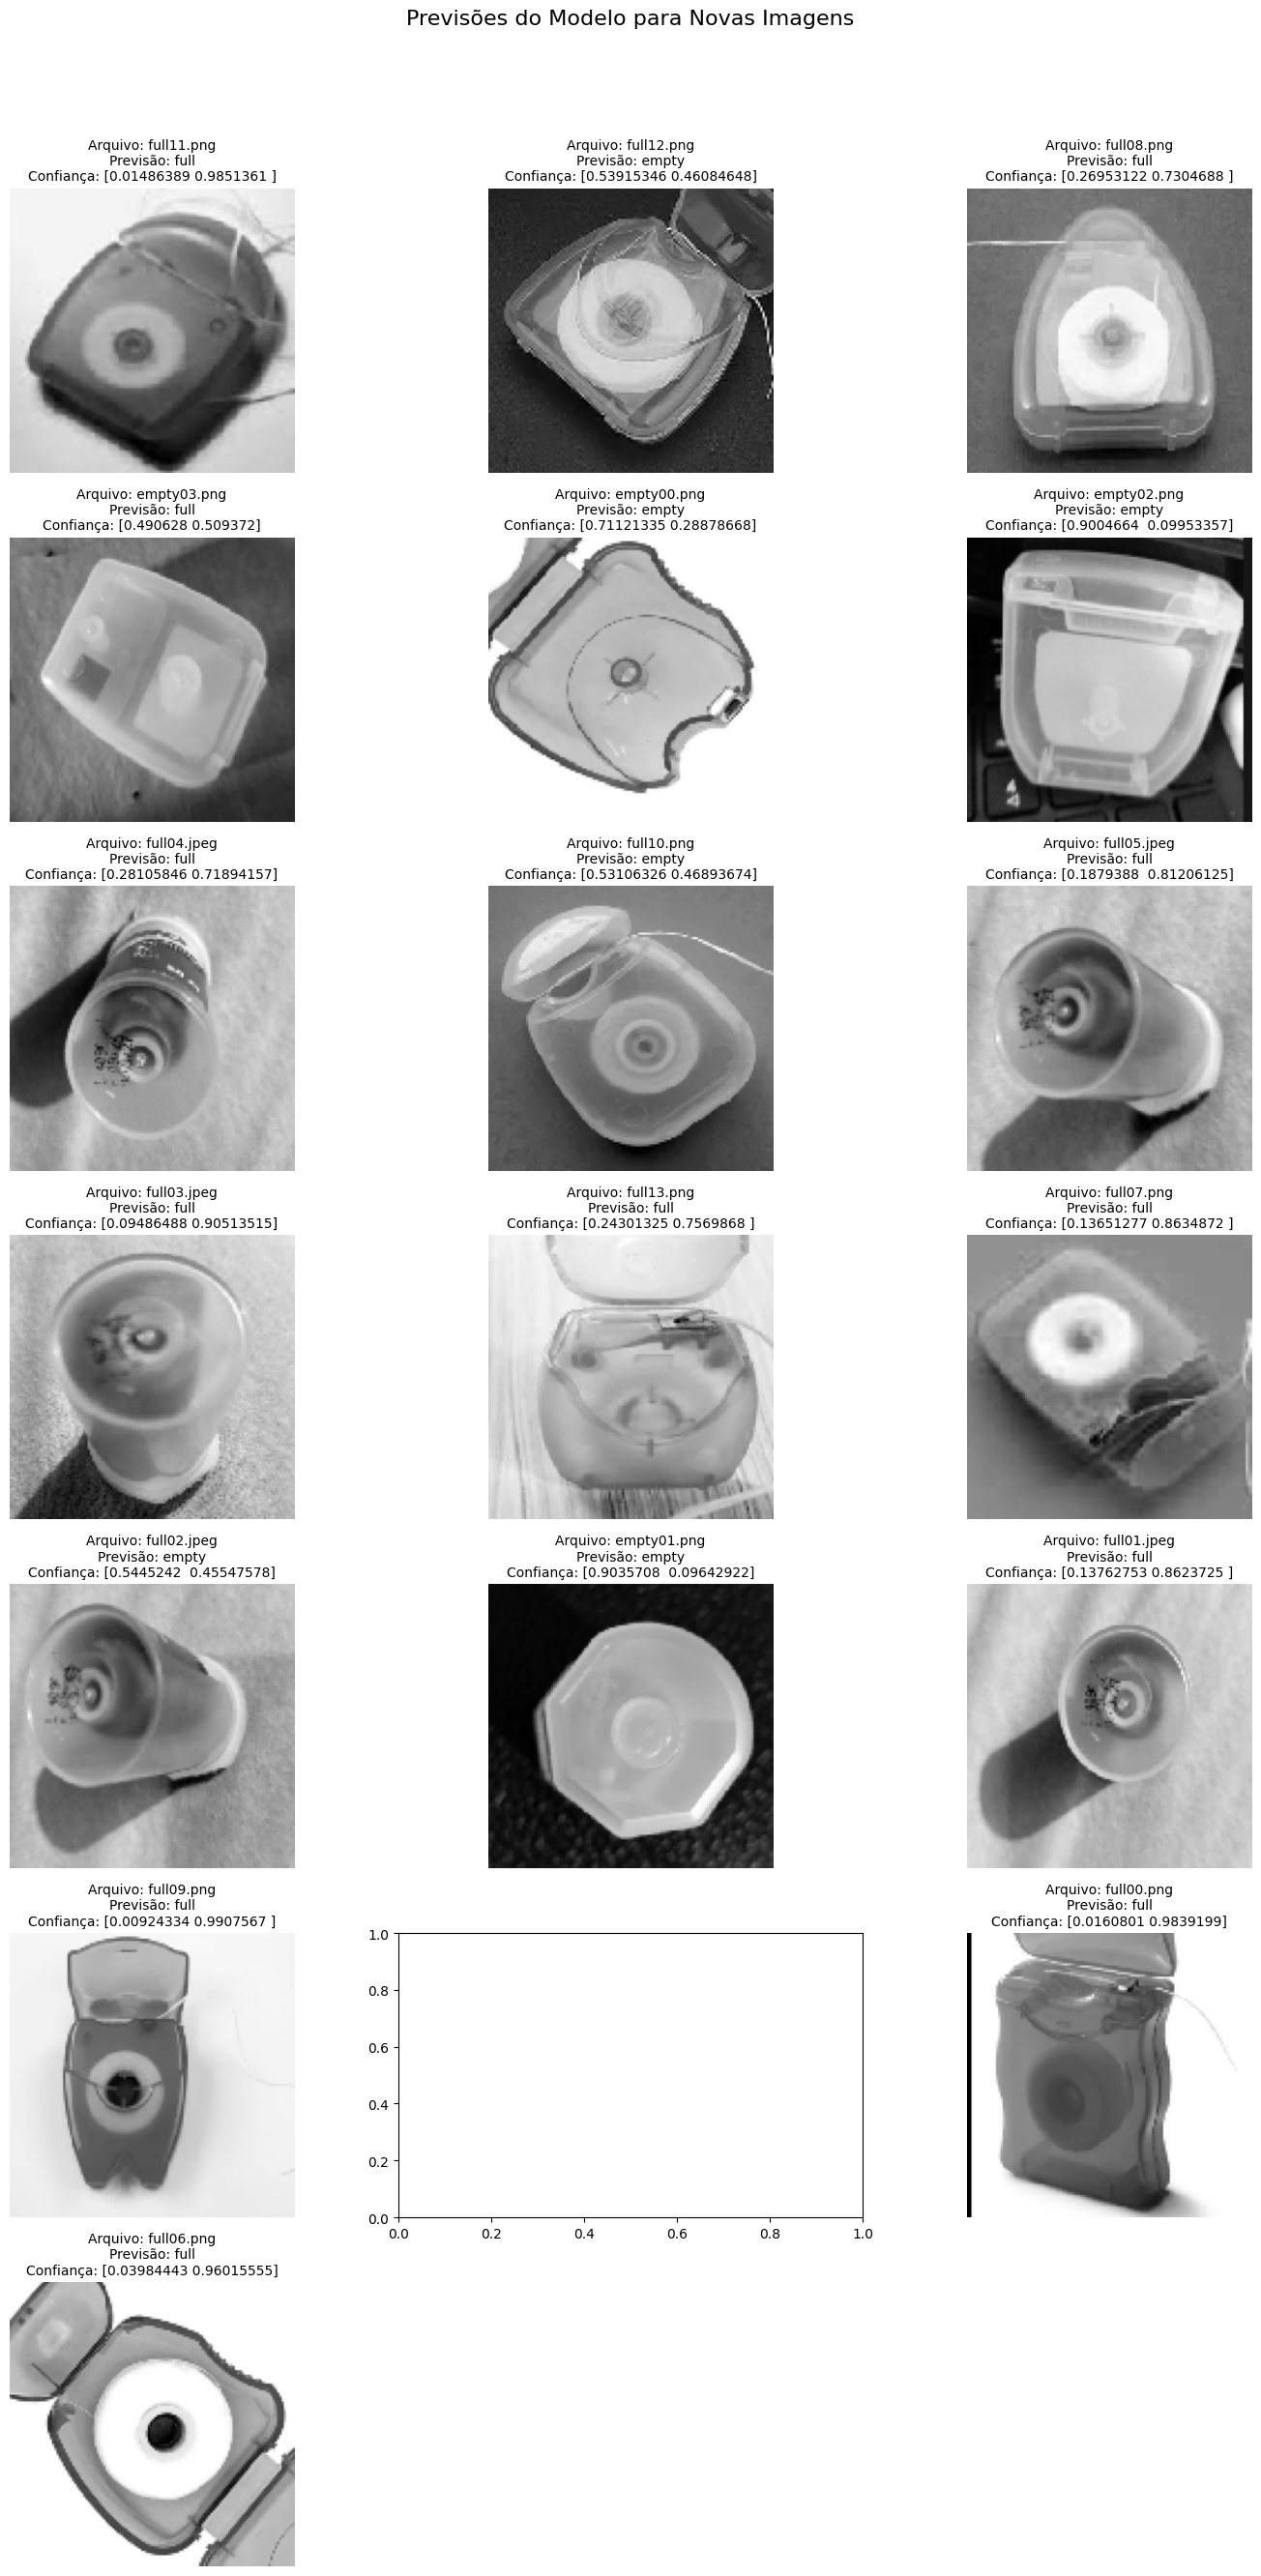

In [177]:
from tensorflow.keras.preprocessing import image

image_folder = '/content/predict/'

image_files = os.listdir(image_folder)

# Define o layout do plot
num_images = len(image_files)
rows = int(np.ceil(num_images / 3))
cols = 3
class_names = ['empty', 'full']

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
fig.suptitle('Previsões do Modelo para Novas Imagens', fontsize=16)

for i, filename in enumerate(image_files):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        full_path = os.path.join(image_folder, filename)

        img = image.load_img(full_path, target_size=(128, 128), color_mode='grayscale')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Adiciona a dimensão do lote
        img_array /= 255.0 # Normaliza

        classe_predita, probabilidades = prever_nova_imagem(full_path, model)

        ax = axes.flat[i] if rows > 1 else axes[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Arquivo: {filename}\nPrevisão: {classe_predita}\n: {probabilidades}", fontsize=10)
        ax.axis('off')

# Ocultar eixos extras se houver
for j in range(len(image_files), rows * cols):
    axes.flat[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Predição com o Gradio

In [154]:
!pip install gradio

In [ ]:
import gradio as gr
from PIL import Image

In [ ]:
class_names = ['empty', 'full']

def classify_image(input_image):
    img = np.array(input_image)

    # redimensionar, converter para escala de cinza e normalizar
    img_resized = tf.image.resize(img, (128, 128))
    img_gray = tf.image.rgb_to_grayscale(img_resized)
    img_normalized = img_gray / 255.0

    # ajuste de formato
    img_tensor = tf.expand_dims(img_normalized, axis=0)

    predictions = model.predict(img_tensor, verbose=0)

    # logits -> probabilidades
    probabilities = tf.nn.softmax(predictions[0]).numpy()

    # retorno das probabilidades
    return {class_names[i]: float(probabilities[i]) for i in range(len(class_names))}

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(),
    title="Classificador de Embalagens Cheias e Vazias",
    description="Faça o upload da foto de uma embalagem para classificá-la como 'cheia' ou 'vazia'."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://caf13b15e6a7d2c6ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Salvado o modelo

In [175]:
model.save('modelo_final.h5')


carrega o modelo salvo


In [ ]:
#from tensorflow.keras.models import load_model

#modelo_carregado = load_model('meu_modelo.h5')